In [1]:
from keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint

from keras.applications import VGG16
from keras.optimizers import SGD
from keras.layers import Dense,GlobalAveragePooling2D

from keras.models import Model

import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import itertools

from keras import backend as K
K.tensorflow_backend._get_available_gpus()

Using TensorFlow backend.


['/job:localhost/replica:0/task:0/device:GPU:0']

In [2]:
train_datagen = ImageDataGenerator(
                rescale= 1./255,
                featurewise_center=False,  # set input mean to 0 over the dataset
                samplewise_center=False,  # set each sample mean to 0
                featurewise_std_normalization=False,  # divide inputs by std of the dataset
                samplewise_std_normalization=False,  # divide each input by its std
                zca_whitening=False,  # apply ZCA whitening
                rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
                zoom_range = 0.1, # Randomly zoom image 
                width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
                height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
                horizontal_flip=False,  # randomly flip images
                vertical_flip=False)

test_datagem = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
                    'data/train',
                    target_size = (224, 224),
                    batch_size = 128,
                    class_mode = 'categorical')

validation_generator = test_datagem.flow_from_directory(
                    'data/validation',
                    target_size = (224, 224),
                    batch_size = 128,
                    class_mode = 'categorical')

teste_generator = test_datagem.flow_from_directory(
                    'data/teste/',
                    target_size = (224, 224),
                    batch_size = 2976,
                    class_mode = 'categorical')

Found 9524 images belonging to 4 classes.
Found 2976 images belonging to 4 classes.
Found 2380 images belonging to 4 classes.


In [3]:
name = "testeSGD"
tensorbord = TensorBoard(log_dir='logs/{}'.format(name))
stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
# define checkpoints
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [4]:
base_model=VGG16(weights='imagenet',include_top=False) #imports the VGG16 model and discards the last 1000 neuron layer.

x=base_model.output
x=GlobalAveragePooling2D()(x)
x=Dense(1024,activation='relu')(x) #we add dense layers so that the model can learn more complex functions and classify for better results.
x=Dense(1024,activation='relu')(x) #dense layer 2
x=Dense(512,activation='relu')(x) #dense layer 3
preds=Dense(4,activation='softmax')(x) #final layer with softmax activation

Instructions for updating:
Colocations handled automatically by placer.


In [5]:
model=Model(inputs=base_model.input,outputs=preds)

for layer in model.layers[:20]:
    layer.trainable=False
for layer in model.layers[20:]:
    layer.trainable=True

In [6]:
epochs = 50
sgd = SGD(lr=0.0001, momentum=0.9, decay=1e-2/epochs)

model.compile(optimizer= sgd,loss='categorical_crossentropy',metrics=['accuracy'])


In [7]:
model.fit_generator(train_generator,
                    epochs= epochs,
                    steps_per_epoch = 93,
                    validation_steps = 23,
                    validation_data= validation_generator,
                   callbacks=[tensorbord,stop, checkpoint])

Instructions for updating:
Use tf.cast instead.
Epoch 1/50
93/93 [==============================] - 137s 1s/step - loss: 1.3192 - acc: 0.6128 - val_loss: 1.2537 - val_acc: 0.8614

Epoch 00001: val_acc improved from -inf to 0.86141, saving model to best_model.h5
Epoch 2/50
93/93 [==============================] - 123s 1s/step - loss: 1.2161 - acc: 0.8969 - val_loss: 1.1780 - val_acc: 0.9228

Epoch 00002: val_acc improved from 0.86141 to 0.92275, saving model to best_model.h5
Epoch 3/50
93/93 [==============================] - 123s 1s/step - loss: 1.1424 - acc: 0.9807 - val_loss: 1.1104 - val_acc: 0.9796

Epoch 00003: val_acc improved from 0.92275 to 0.97963, saving model to best_model.h5
Epoch 4/50
93/93 [==============================] - 123s 1s/step - loss: 1.0813 - acc: 0.9615 - val_loss: 1.0511 - val_acc: 0.9986

Epoch 00004: val_acc improved from 0.97963 to 0.99860, saving model to best_model.h5
Epoch 5/50
93/93 [==============================] - 124s 1s/step - loss: 1.0237 - acc: 

93/93 [==============================] - 124s 1s/step - loss: 0.2400 - acc: 0.9992 - val_loss: 0.2343 - val_acc: 0.9993

Epoch 00043: val_acc did not improve from 0.99965
Epoch 44/50
93/93 [==============================] - 123s 1s/step - loss: 0.2341 - acc: 0.9991 - val_loss: 0.2312 - val_acc: 1.0000

Epoch 00044: val_acc improved from 0.99965 to 1.00000, saving model to best_model.h5
Epoch 45/50
93/93 [==============================] - 123s 1s/step - loss: 0.2306 - acc: 0.9985 - val_loss: 0.2256 - val_acc: 0.9996

Epoch 00045: val_acc did not improve from 1.00000
Epoch 46/50
93/93 [==============================] - 120s 1s/step - loss: 0.2248 - acc: 0.9993 - val_loss: 0.2200 - val_acc: 0.9996

Epoch 00046: val_acc did not improve from 1.00000
Epoch 47/50
93/93 [==============================] - 123s 1s/step - loss: 0.2195 - acc: 0.9995 - val_loss: 0.2164 - val_acc: 0.9972

Epoch 00047: val_acc did not improve from 1.00000
Epoch 48/50
93/93 [==============================] - 122s 1s/s

In [11]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [33]:
X = teste_generator.next()
X_test = X[0]
y_test = X[1]

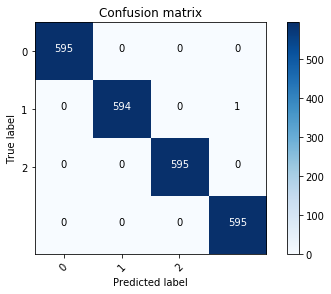

In [38]:
# Predict the values from the validation dataset
Y_pred = model.predict(X_test)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_test,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(3)) 

In [39]:
soma_acerto = confusion_mtx[0][0]+confusion_mtx[1][1]+confusion_mtx[2][2]
soma_erro = confusion_mtx[0][1]+confusion_mtx[0][2]+ confusion_mtx[1][0]+confusion_mtx[1][2]+confusion_mtx[2][0]+confusion_mtx[0][1]
total = confusion_mtx.sum()
acc = soma_acerto/total
error = soma_erro/total
acc ,error

(0.7495798319327731, 0.0)